# Engineering Time-Varying Social Capital Features for Predictive Modeling

To predict who would sustain long careers vs. exit the industry, we need features that evolve as careers unfold. Networks are a natural place to look: filmmaking is inherently collaborative, and a director’s opportunities often depend on the network around them — the teammates who bridge them to new circles or those who keep them in tightly knit groups.

In this notebook, I build the time-varying social capital landscape for the entire film industry. Using two decades of IMDb collaboration data, I construct rolling three-year collaboration networks for each year from 2003 to 2023 and compute brokerage metrics — constraint, effective size, and local clustering — for every creative worker. These industry-level signals form the foundation for later modeling, where they’ll be mapped onto directors’ career timelines to test whether network position helps explain career longevity.

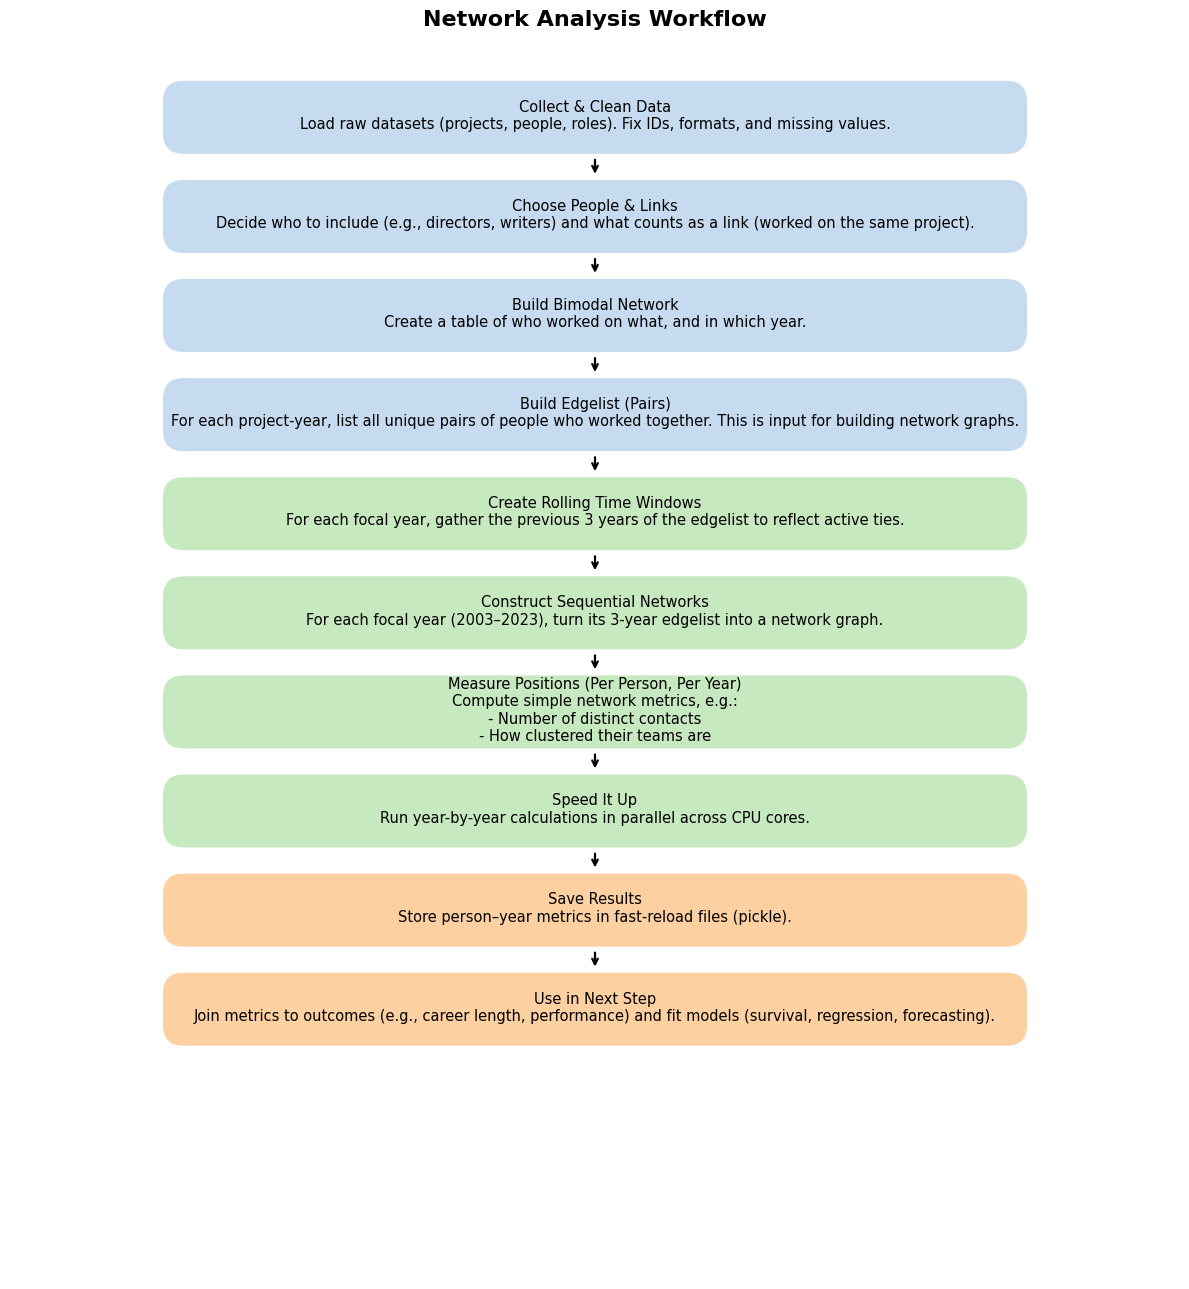

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# --- Figure (tall for clean spacing) ---
fig, ax = plt.subplots(figsize=(12, 13))
ax.axis("off")

# --- Colors by phase ---
colors = {
    "data": "#c6dbef",      # data collection / cleaning
    "analysis": "#c7e9c0",  # analysis / modeling
    "output": "#fdd0a2"     # saving / hand-off
}

# --- Workflow steps (beginner-friendly, with edgelist + 21 networks) ---
steps = [
    ("Collect & Clean Data",
     "Load raw datasets (projects, people, roles). Fix IDs, formats, and missing values.",
     "data"),
    ("Choose People & Links",
     "Decide who to include (e.g., directors, writers) and what counts as a link (worked on the same project).",
     "data"),
    ("Build Bimodal Network",
     "Create a table of who worked on what, and in which year.",
     "data"),
    ("Build Edgelist (Pairs)",
     "For each project-year, list all unique pairs of people who worked together. This is input for building network graphs.",
     "data"),
    ("Create Rolling Time Windows",
     "For each focal year, gather the previous 3 years of the edgelist to reflect active ties.",
     "analysis"),
    ("Construct Sequential Networks",
     "For each focal year (2003–2023), turn its 3-year edgelist into a network graph.",
     "analysis"),
    ("Measure Positions (Per Person, Per Year)",
     "Compute simple network metrics, e.g.:\n- Number of distinct contacts\n- How clustered their teams are",
     "analysis"),
    ("Speed It Up",
     "Run year-by-year calculations in parallel across CPU cores.",
     "analysis"),
    ("Save Results",
     "Store person–year metrics in fast-reload files (pickle).",
     "output"),
    ("Use in Next Step",
     "Join metrics to outcomes (e.g., career length, performance) and fit models (survival, regression, forecasting).",
     "output"),
]

# --- Layout parameters (spacious to avoid overlaps) ---
N = len(steps)
top_margin = 0.95
bottom_margin = 0.05
usable_height = top_margin - bottom_margin

box_h = 0.001          # box height (taller than before)
v_gap = 0.08          # vertical gap between boxes
step_pitch = box_h + v_gap

left = 0.16            # left x for boxes
box_w = 0.68           # width for readable text
text_pad_y = 0.002
arrow_clear = 0.006    # small space so arrows start/stop outside the boxes

# --- Draw boxes + arrows ---
for i, (title, text, category) in enumerate(steps):
    color = colors[category]

    # Compute box geometry
    y_top = top_margin - (i * step_pitch)       # top edge of current row band
    y_box_bottom = y_top - box_h              # bottom edge of the box

    # Rounded rectangle
    box = FancyBboxPatch(
        (left, y_box_bottom), box_w, box_h,
        boxstyle="round,pad=0.03,rounding_size=0.018",
        facecolor=color, edgecolor="white", linewidth=1.2
    )
    ax.add_patch(box)

    # Text
    ax.text(
        left + box_w / 2,
        y_box_bottom + box_h / 2 + text_pad_y,
        f"{title}\n{text}",
        ha="center", va="center",
        fontsize=10.5, fontweight="medium"
    )

    # Arrow from bottom of this box to TOP of next box (i+1), staying in the gap
    if i < N - 1:
        next_y_top = top_margin - ((i + 1) * step_pitch)    # top edge of next row band
        # arrow start and end in the gap, not at box edges
        y_start = y_box_bottom - 0.4 * v_gap
        y_end = next_y_top + 0.4 * v_gap


        ax.annotate(
            "",
            xy=(left + box_w / 2, y_end),
            xytext=(left + box_w / 2, y_start),
            arrowprops=dict(arrowstyle="->", lw=1.6, color="black")
        )
        

# --- Title ---
plt.title(
    "Network Analysis Workflow",
    fontsize=16, fontweight="bold", pad=22
)

plt.tight_layout()
plt.show()

# Import and Setup

In [ ]:
# Imports
import pandas as pd                   # DataFrames
import os                             # File operations
import itertools                      # Itertools utilities
import networkx as nx                 # Network analysis
import random                         # Random sampling
from collections import deque         # FIFO queue
import multiprocessing as mp          # Parallel processing
import pickle                         # Object serialization
import matplotlib.pyplot as plt       # Static plotting
import numpy as np                    # Numeric operations
import plotly.graph_objects as go     # Interactive plotting
import plotly.io as pio               # Plotly I/O

# Set project directory
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# Identifying creative workers 

To build these networks, we first identify the creative workers behind films—directors, writers, producers, editors, cinematographers, production designers, and composers. These roles form the nodes of our collaboration network.

The result is a clean “who worked with whom, and when” dataset, which forms the raw material for constructing yearly collaboration networks and computing each person’s social capital.

In [ ]:
# Load movie list (2000–2023)
movies_2000_2023 = pd.read_csv('movies_2000_2023.csv')
movies_2000_2023.head()

,tconst,startYear,genres
0,tt0011801,2019.0,"Action,Crime"
1,tt0013274,2021.0,Documentary
2,tt0015414,2000.0,\N
3,tt0028248,2022.0,Musical
4,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [ ]:
# Load IMDb principals to get creative contributors
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

# Filter for core creative roles
creative_roles = [
    'director', 'producer', 'writer', 'editor', 
    'cinematographer', 'production_designer', 'composer'
]
df_principals = df_principals[df_principals['category'].isin(creative_roles)]

# Link movies with their creative teams
movies_collaborations_2000_2023 = (
    df_principals[['tconst', 'nconst', 'category']]
    .merge(movies_2000_2023[['tconst', 'startYear']], on='tconst', how='inner')
)
movies_collaborations_2000_2023.to_csv('movies_collaborations_2000_2023.csv' , index=False)

In [ ]:
# Inspect data
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


In [ ]:
# Count distinct movies, people, and roles
movies_collaborations_2000_2023.nunique()

tconst       296524
nconst       571851
category          7
startYear        24
dtype: int64

Our network comprise 571,851 creative workers who worked on 296,524 movies. From here, we’ll build the networks that let us quantify the levels of social capital embedded in these collaborations.

# Understanding the scale of production and collaboration

Before building networks, it’s helpful to understand the scale of collaboration in the film industry. Each year from 2000–2023, we track:

- number of films released
- number of creative workers credited
- average team size per film

In [ ]:
# === Annual scale & team structure ===

# Aggregate yearly counts:
# - num_movies: distinct titles produced in a year
# - num_creative_workers: distinct people credited in core creative roles in that year
count_movies_people = movies_collaborations_2000_2023.groupby('startYear').agg(
    num_movies=('tconst', pd.Series.nunique),
    num_creative_workers=('nconst', pd.Series.nunique)
)

# Average creative team size per movie per year:
# 1) within each (year, movie) count unique people
# 2) average those counts across movies in the year
creative_team_size = (
    movies_collaborations_2000_2023
    .groupby(['startYear', 'tconst'])['nconst']
    .nunique()
)
average_creative_team_size = (
    creative_team_size
    .groupby('startYear')
    .mean()
    .rename('average_creative_team_size')
)

# Merge the annual summaries into a single frame for plotting
summary_df = (
    pd.merge(count_movies_people, average_creative_team_size, on='startYear')
    .reset_index()
)

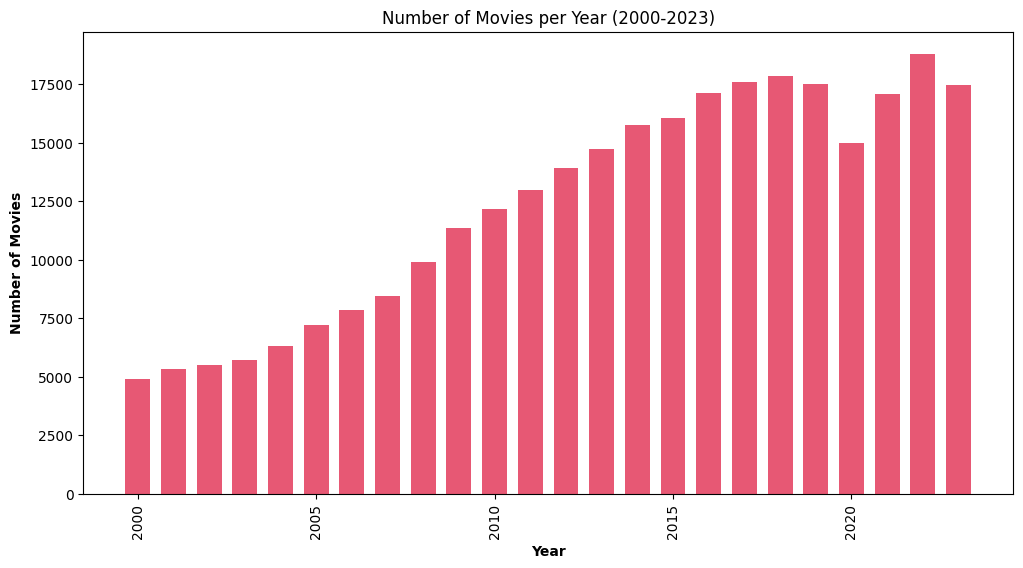

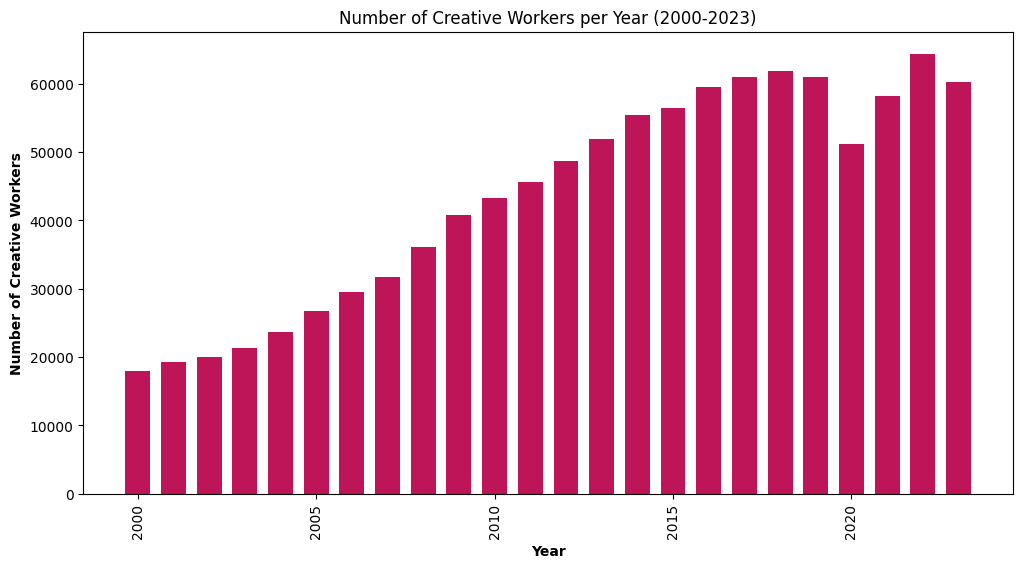

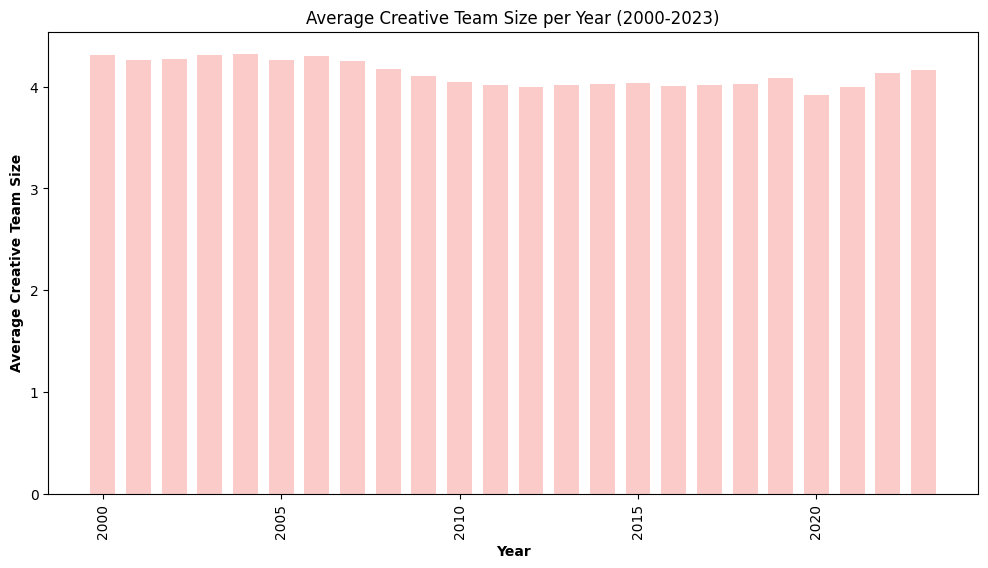

In [ ]:
# Plot yearly trends
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_movies'], color='#e75874', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.title('Number of Movies per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_creative_workers'], color='#be1558', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Creative Workers', fontweight='bold')
plt.title('Number of Creative Workers per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['average_creative_team_size'], color='#fbcbc9', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Creative Team Size', fontweight='bold')
plt.title('Average Creative Team Size per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

Production rose steadily through the 2000s, nosedived in 2020 with COVID-19 shutdowns, and rebounded quickly by 2022. The workforce followed the same rhythm. Yet creative team sizes remained remarkably stable. This tells us something about collaboration norms: while industry volume fluctuates with economic shocks and technological shifts, the fundamental structure of how films get made—the core creative team size—remains steady.

Careers are not lived in isolated years. Opportunities spill over time. To capture that, we build three-year rolling windows. For a focal year (say 2010), we look at the previous three years of films (2007–2009). This is our proxy for “active social capital”: the collaborations that are recent enough to still shape opportunities.

To understand the scale at which creative collaboration operates, for each window, we calculate:

- The number of films produced.

- The number of unique people involved.

- The average size of film teams.

- And an upper bound on possible pairwise connections—calculated as n × (n–1)/2.

In [ ]:
# === Rolling 3-year windows (industry "surface" seen by a focal year) ===
# For a focal year y, we combine years [y-3, y-1].

# Initialize a list to store counts for each 3-year moving window
window_counts = []

# Loop through each year to calculate the counts for each 3-year moving window
for year in range(2003, 2024):  # From 2003 to 2023
    start_year = year - 3  # Start of the 3-year window
    end_year = year - 1    # End of the 3-year window

    # Filter the data for the current window
    window_data = movies_collaborations_2000_2023[
        movies_collaborations_2000_2023['startYear'].between(start_year, end_year)
    ]

    # Count the unique number of movies and people in the window
    num_movies = window_data['tconst'].nunique()
    num_people = window_data['nconst'].nunique()

    # Calculate the average team size
    avg_team_size = window_data.groupby('tconst')['nconst'].nunique().mean()

    # Append the counts to the list
    window_counts.append({
        'Window Start': start_year,
        'Window End': end_year,
        'Number of Movies': num_movies,
        'Number of People': num_people,
        'Average Team Size': avg_team_size
    })

# Convert the list of counts into a DataFrame
window_counts_df = pd.DataFrame(window_counts)

# Calculate potential connections for each window = n*(n-1)/2
window_counts_df['Potential Connections'] = window_counts_df['Number of People'].apply(lambda n: n * (n - 1) / 2)

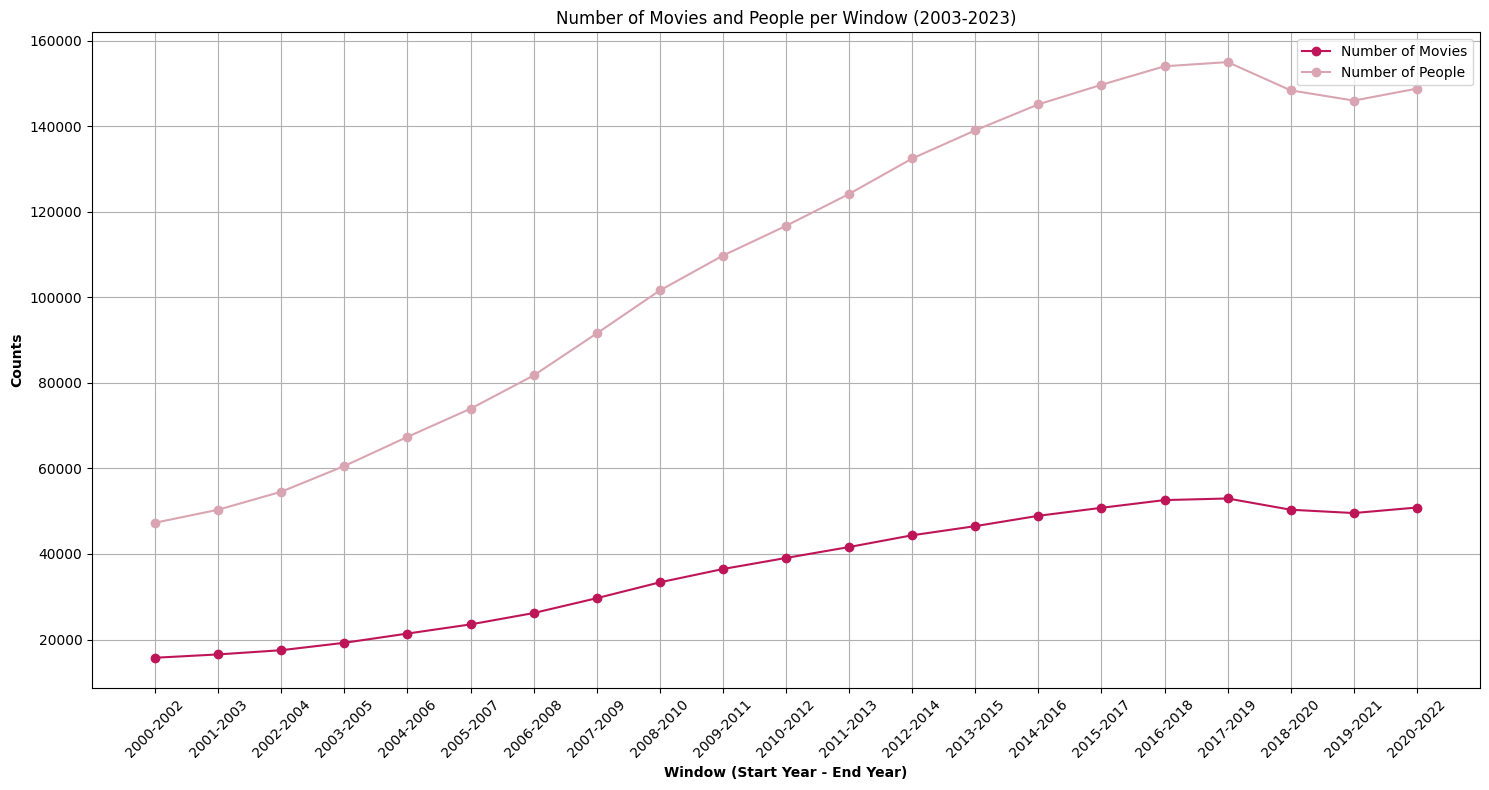

In [ ]:
# Visualize the number of movies and people in each 3-year moving window 
r1 = np.arange(len(window_counts_df))
plt.figure(figsize=(15, 8))
plt.plot(r1, window_counts_df['Number of Movies'], marker='o', color='#be1558', label='Number of Movies')
plt.plot(r1, window_counts_df['Number of People'], marker='o', color='#d9a5b3', label='Number of People')
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)
plt.legend()
plt.title('Number of Movies and People per Window (2003-2023)')
plt.tight_layout()
plt.grid(True)
plt.show()


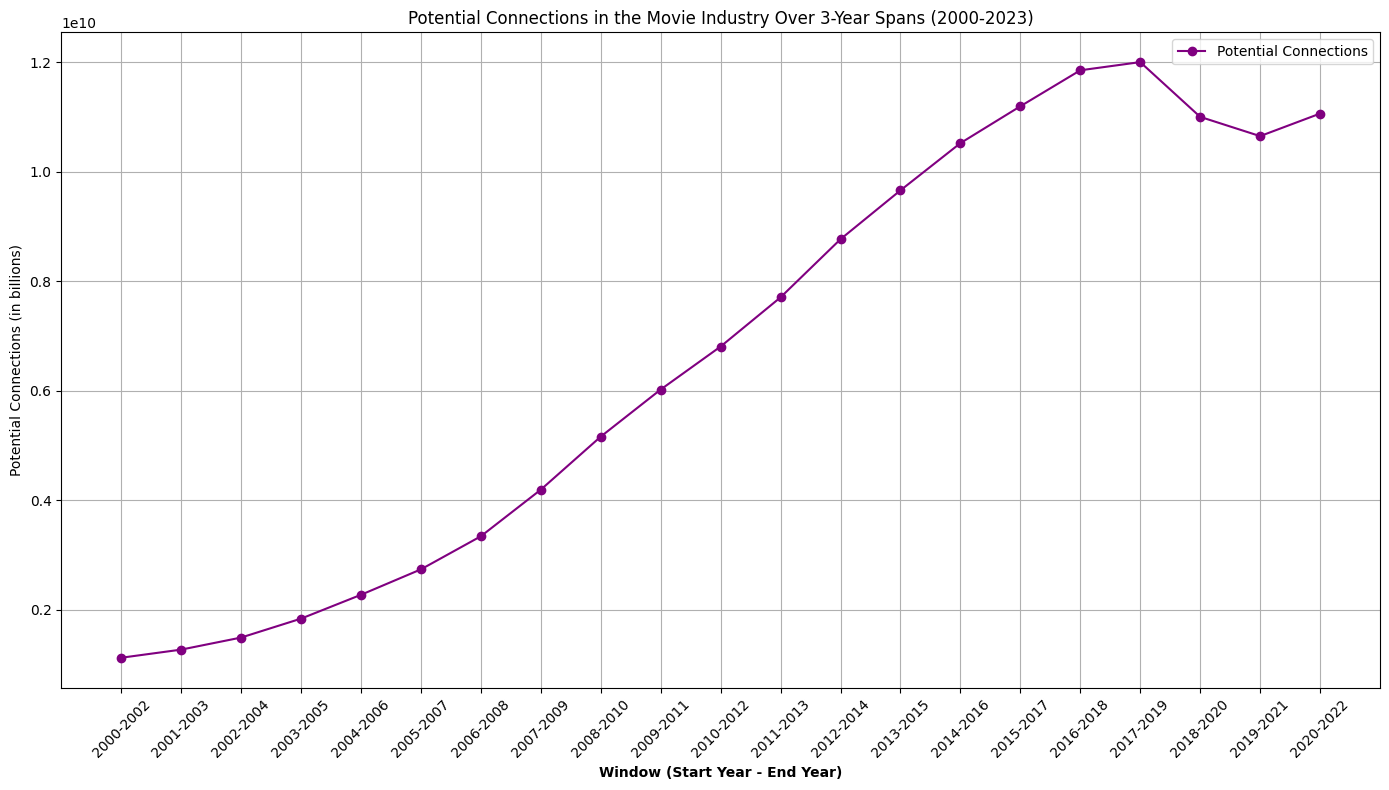

In [ ]:
# Visualize the number of potential connections in each 3-year moving window 
r1 = np.arange(len(window_counts_df))
plt.figure(figsize=(14, 8))
plt.plot(r1, window_counts_df['Potential Connections'], marker='o', color='purple', label='Potential Connections')
plt.title('Potential Connections in the Movie Industry Over 3-Year Spans (2000-2023)')
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Potential Connections (in billions)')
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The results show how social network scales. The smallest network (2000–2002) had ~47,000 workers; by 2017–2019, that number more than tripled to ~155,000. Potential connections ballooned to 12 billion in the same period. This illustrates the combinatorial nature of networks: each new entrant doesn’t just add one more dot, but exponentially multiplies the possibilities for new connections.

# Building dynamic collaboration networks and measuring social capital of network members

Next, I turn the film industry’s credit lists into dynamic collaboration networks. For each focal year (2003–2023), I construct a network using the previous three years of films—capturing ties that are recent enough to shape current opportunities.

For every creative worker, I compute three core brokerage metrics:

- Constraint — how closed or redundant their network is  
- Effective size — the number of non-overlapping contacts they have  
- Local clustering — how tightly knit their immediate neighborhood is  

Together, these metrics quantify a person’s structural position: whether they are embedded in dense teams, bridging across groups, or somewhere in between.

**Scaling the Computation with Parallel Processing**

The dataset is massive, with hundreds of thousands of people and + 100 billion potential ties. To make the workflow scalable, I parallelize the network computations: each processor handles a different year’s rolling-window network, allowing the full 21-year series to be computed efficiently.

This produces a dictionary of brokerage scores for every creative worker, every year—ready to merge with directors’ career trajectories in the modeling stage.

## Writing parallel processing functions to construct several networks concurrently

To optimize performance in the Jupyter Notebook environment, we externalize our main functions to calculate social capital into separate Python scripts. This separation ensures that each processor can independently access and execute these functions. 

In [3]:
# Define a function to calculate various brokerage social capital metrics for a specified year and set of edges
# This function is placed in a separate Python script named "network_analysis_function.py" for parallel processing
def calculate_social_capital(year, edges_by_year):
    
    # Initialize a rolling window to accumulate edges over a 3-year period
    rolling_edges = deque()

    # For each year in the 3-year window leading up to the focal year, add the edges to the rolling window
    for y in range(year - 3, year):
        edges = edges_by_year.get(y, []) # Retrieve edges for the year 'y', defaulting to an empty list if not found
        rolling_edges.extend(edges) # Add these edges to the rolling window
    
    # Create a graph (network) using the edges accumulated in the rolling window
    G = nx.Graph()
    G.add_edges_from(rolling_edges) # Add the edges to the graph
    
    # Calculate brokerage scores for the nodes
    brokerage_scores = {
        # Constraint measures the extent to which a node's connections are to others that are connected to each other
        'constraint': nx.constraint(G), 
        # Effective size is a measure of the number of non-redundant contacts a node has
        'effective_size': nx.effective_size(G), 
        # Local clustering coefficient measures the degree to which nodes in a graph tend to cluster together
        'local_clustering': nx.clustering(G) 
    }
    return year, brokerage_scores

In [ ]:
# Wrapper function for parallel processing
# This function is placed in a separate Python script named "parallel_functions.py" for parallel processing
def calculate_social_capital_wrapper(year, edges_by_year):
    # Call the main function to calculate social capital metrics for a given year and its edges
    return calculate_social_capital(year, edges_by_year)

## Applying the functions to the data

Now we apply the social capital calculation functions to the dataset that captures the collaborative ties among creative individuals in the film industry from 2000 to 2023. 

In [ ]:
# Apply the same process to the actual dataset of movie collaborations
# Load the real dataset containing movie collaborations from 2000 to 2023
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

from parallel_functions import calculate_social_capital_wrapper 

def create_pairs(group):
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

if __name__ == "__main__":
    # Group the real dataset by movie and year, and create pairs of collaborators
    movies_collaborations_2000_2023 = movies_collaborations_2000_2023.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year 
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in movies_collaborations_2000_2023.groupby('startYear')}

    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process
    years = range(2003, 2024)
    
    # Calculate brokerage scores for each year in parallel 
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Collect the calculated brokerage scores by year 
    brokerage_scores_by_year = {year: scores for year, scores in results}
    
    # Save the calculated brokerage scores as a pickle file for future use
    with open('brokerage_scores_by_year.pkl', 'wb') as f:
        pickle.dump(brokerage_scores_by_year, f)

## Examining the Results

After processing, the brokerage scores for each year are stored into a dictionary. This structure pairs each year—starting from 2003—with a set of brokerage social capital metrics ("constraint", "effective size", and "local clustering"). Each creative worker in the network is uniquely identified by a code, linking them directly to their annual brokerage scores.

In [5]:
# Checking the contents and structure of the data

# Print the dictionary keys, which are the years for which data is available.
# This is to ensure the data covers the expected timeframe.
print("Years in the dataset:", list(brokerage_scores_by_year.keys()))

Years in the dataset: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [6]:
# Check the structure of a nested dictionary by picking a sample year
sample_year = next(iter(brokerage_scores_by_year))  # Get the first year in the dictionary
# Print the keys of the nested dictionary for the first year in the data, which are the types of brokerage scores available.
print(f"Brokerage score types available in {sample_year}:", list(brokerage_scores_by_year[sample_year].keys()))

Brokerage score types available in 2003: ['constraint', 'effective_size', 'local_clustering']


In [7]:
# Pick one type of score to sample, for example 'constraint'
score_type = 'constraint'
# Sample 10 random IDs within the 'constraint' scores
sample_ids = random.sample(list(brokerage_scores_by_year[sample_year][score_type].keys()), 10)
# Print the constraint scores for the randomly selected people
print(f"Random sample of {score_type} scores for {sample_year}:")
for nconst in sample_ids:
        print(f"ID {nconst}: {brokerage_scores_by_year[sample_year][score_type][nconst]}")

Random sample of constraint scores for 2003:
ID nm1516921: 0.925925925925926
ID nm3823083: 1.125
ID nm1178382: 0.5236734693877553
ID nm0829044: 0.14983323429927986
ID nm14765105: 1.0
ID nm0129515: 0.571825
ID nm9885971: 0.45350059171597645
ID nm0959197: 0.7218651158045097
ID nm0074404: 0.462962962962963
ID nm0001952: 0.4169136094674556


# Summary

This notebook builds the dynamic collaboration networks in the film industry for two decades. I constructed rolling three-year networks for 2003–2023, computed brokerage metrics (constraint, effective size, clustering) for every creative worker in the industry, and automated the workflow to scale across hundreds of thousands of people and billions of potential ties.

The output is a time-varying dataset describing the social capital available in the industry each year. In the next notebook, these industry-level metrics will be joined to directors’ actual collaborators and converted into director-year features for survival modeling.
